# Business Portfolio Project

## Loading and Verification

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
df = pd.read_csv('sales_data.csv')

In [17]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11631 entries, 0 to 11630
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     11631 non-null  object
 1   rating                    11582 non-null  object
 2   number_of_reviews         11582 non-null  object
 3   bought_in_last_month      10702 non-null  object
 4   current/discounted_price  8519 non-null   object
 5   price_on_variant          11631 non-null  object
 6   listed_price              11631 non-null  object
 7   is_best_seller            11631 non-null  object
 8   is_sponsored              11631 non-null  object
 9   is_couponed               11631 non-null  object
 10  buy_box_availability      7834 non-null   object
 11  delivery_details          8524 non-null   object
 12  sustainability_badges     1156 non-null   object
 13  image_url                 11631 non-null  object
 14  product_url           

,title,rating,number_of_reviews,bought_in_last_month,current/discounted_price,price_on_variant,listed_price,is_best_seller,is_sponsored,is_couponed,buy_box_availability,delivery_details,sustainability_badges,image_url,product_url,collected_at
count,11631,11582,11582,10702,8519,11631,11631,11631,11631,11631,7834,8524,1156,11631,10957,11630
unique,8493,30,4295,49,2481,3364,877,4,2,33,1,197,16,7752,10957,406
top,"Duracell Coppertop 9V Battery, 6 Count (Pack o...",4.7 out of 5 stars,8,100+ bought in past month,179.99,basic variant price: nan,No Discount,No Badge,Organic,No Coupon,Add to cart,"Delivery Mon, Sep 1",Small Business,https://m.media-amazon.com/images/I/51Xr76m2WL...,/PowerA-Stereo-Headset-Nintendo-Gaming-Console...,2025-08-21 11:22:39
freq,244,1778,232,1515,263,5482,8306,11226,9354,11018,7834,5931,420,324,1,33


In [18]:
df.price_on_variant.value_counts()


,count
price_on_variant,
basic variant price: nan,5482
basic variant price: 16 Count (Pack of 1),208
basic variant price: USB,119
basic variant price: $8.99,47
basic variant price: $7.99,38
...,...
basic variant price: $789.00,1
basic variant price: $27.67,1
basic variant price: $128.40,1


In [21]:
final_df.isnull().sum()

,0
title,0
rating_numeric,41
number_of_reviews,0
bought_in_last_month_clean,0
original_price,454
discounted_price,454
discount_amount,454
discount_percentage,0
buy_box_availability,0
delivery_details,0


## Cleaning

In [5]:
def cleaned_up_code(rows_of_data, debug=False):
  df = rows_of_data.copy()
  fill_zero_cols = ['number_of_reviews', 'bought_in_last_month'] #Either has 0 reviews/purchases or has 1
  fill_blank_cols = ['product_url', 'delivery_details', 'buy_box_availability','sustainability_badges'] #Should be blanks

#Cleaning of 0's, blanks, and Unknowns
  for col in fill_zero_cols:
    if col in df.columns:
      df[col] = df[col].fillna(0)
  for col in fill_blank_cols:
    if col in df.columns:
      df[col] = df[col].fillna('').astype(str)
  if 'rating' in df.columns:
    df['rating_numeric'] = pd.to_numeric(
      df['rating'].astype(str).str.extract(r'(\d+\.\d+)')[0], errors='coerce'
    )
 # -------------------------
  def clean_prices(df):
    df = df.copy()
    # Clean current/discounted_price
    if 'current/discounted_price' in df.columns:
        df['discounted_price'] = pd.to_numeric(df['current/discounted_price'], errors='coerce')
    else: df['discounted_price'] = np.nan

    # Extract numeric from price_on_variant
    def extract_variant_price(x):
      if pd.isna(x):
          return np.nan
      match = re.search(r'(\d*\.?\d+)', str(x))
      return float(match.group(1)) if match else np.nan

    if 'price_on_variant' in df.columns:
        df['price_on_variant_clean'] = df['price_on_variant'].apply(extract_variant_price)
    else:df['price_on_variant_clean'] = np.nan

    # Clean listed_price
    def clean_listed_price(x, discounted):
        try: return float(str(x).replace('$',''))
        except: return discounted
    if 'listed_price' in df.columns:
        df['listed_price_clean'] = df.apply(
            lambda row: clean_listed_price(row['listed_price'], row['discounted_price']), axis=1
        )
    else: df['listed_price_clean'] = df['discounted_price']

    #Determines original_price with consistent fallback
    def determine_original(row):
      if pd.notna(row['listed_price_clean']):
          return row['listed_price_clean']
      elif pd.notna(row['price_on_variant_clean']):
          return row['price_on_variant_clean']
      elif pd.notna(row['discounted_price']):
          return row['discounted_price']
      else:
          return np.nan
    df['original_price'] = df.apply(determine_original, axis=1)
    df['discounted_price'] = df['discounted_price'].fillna(df['original_price'])

    # Discount metrics
    df['discount_amount'] = df['original_price'] - df['discounted_price']
    df['discount_percentage'] = np.where(
        df['original_price'] > 0, (df['discount_amount'] / df['original_price']) * 100, 0
    )

    # Convert is_couponed to true/false
    if 'is_couponed' in df.columns:
        df['has_coupon'] = df['is_couponed'].str.lower().eq('yes')
    else:
        df['has_coupon'] = False

    return df[['original_price','discounted_price','discount_amount','discount_percentage','has_coupon']]

  # Apply price cleanup if any relevant columns exist
  price_cols = {'listed_price','price_on_variant','current/discounted_price','is_couponed'}
  if price_cols.intersection(df.columns):
      price_df = clean_prices(df)
      df = pd.concat([df, price_df], axis=1)

  def extract_numeric_column(col, remove_text=None, special_cases=None):
    """
    - Convert a messy text column into numeric.
    - remove_text: list of characters to strip
    - special_cases: list of strings to treat as NaN
    """
    col_str = col.astype(str)
    def converter(x):
        val = str(x).lower().strip()
        if special_cases:
            for case in special_cases:
                if case.lower() in val:
                    return np.nan
        if remove_text:
            for txt in remove_text:
                val = val.replace(str(txt).lower(), '')
        val = re.sub(r'basic variant price[:\s]*', '', val) #basic variant price is making it difficult to numerically plot it
        val = val.replace(',', '').strip() #removes commas and blank spaces
        match = re.search(r'(\d*\.?\d+)', val) #looks for any unnessacary letter/words in numbers
        if match:
            number = float(match.group(1))
            if 'k' in val:
                number *= 1000
            return number
        try:
            return float(x)
        except:
            return np.nan
    return col_str.apply(converter)

  if 'bought_in_last_month' in df.columns:
          df['bought_in_last_month_clean'] = extract_numeric_column(
              df['bought_in_last_month'], remove_text=['+']
          ).fillna(0)

  if debug: #helps me figure out where I went wrong
      print("\n[DEBUG] Sample of cleaned numeric columns:")
      numeric_cols = ['bought_in_last_month_clean', 'price_on_variant_clean', 'listed_price_clean']
      for col in numeric_cols:
          if col in df.columns:
              print(col, df[col].head())

  drop_cols = ['bought_in_last_month', 'price_on_variant', 'listed_price', 'rating']
  drop_cols = [col for col in drop_cols if col in df.columns]
  df.drop(columns=drop_cols, inplace=True)

  numeric_cols = ['number_of_reviews','bought_in_last_month_clean','listed_price_clean',
                'price_on_variant_clean','rating_numeric','original_price','discounted_price',
                'discount_amount','discount_percentage']
  for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

  agg_dict = {}
  numeric_agg_map = {
      'rating_numeric': 'mean',
      'number_of_reviews': 'sum',
      'bought_in_last_month_clean': 'sum',
      'listed_price_clean': lambda x: x.mean() if len(x.dropna()) > 0 else np.nan,
      'price_on_variant_clean': 'mean',
      'original_price': 'mean',
      'discounted_price': 'mean',
      'discount_amount': 'mean',
      'discount_percentage': 'mean'
  }
  for col, agg in numeric_agg_map.items():
        if col in df.columns:
            agg_dict[col] = agg

  string_cols = ['buy_box_availability','delivery_details','sustainability_badges','product_url']
  for col in string_cols:
      if col in df.columns:
          agg_dict[col] = 'first'

  if 'title' in df.columns:
    grouped_df = df.groupby('title', dropna=False).agg(agg_dict).reset_index()
    for col in string_cols:
        if col in grouped_df.columns:
            grouped_df[col] = grouped_df[col].fillna('Unknown').astype(str)
  else:
    grouped_df = df.copy()

  if debug:
      print("\n[DEBUG] Sample of cleaned numeric columns:")
      for col in numeric_cols:
          if col in grouped_df.columns:
              print(col, grouped_df[col].head())

  return grouped_df

In [6]:
cleaned_df = cleaned_up_code(df, debug=True)
print(cleaned_df.head())


[DEBUG] Sample of cleaned numeric columns:
bought_in_last_month_clean 0      300.0
1     6000.0
2     2000.0
3    10000.0
4    10000.0
Name: bought_in_last_month_clean, dtype: float64

[DEBUG] Sample of cleaned numeric columns:
number_of_reviews 0    136.0
1      0.0
2    141.0
3      0.0
4      0.0
Name: number_of_reviews, dtype: float64
bought_in_last_month_clean 0    200.0
1    500.0
2     50.0
3    300.0
4    500.0
Name: bought_in_last_month_clean, dtype: float64
rating_numeric 0    4.2
1    4.7
2    4.7
3    4.6
4    4.7
Name: rating_numeric, dtype: float64
original_price 0    169.96
1     19.17
2    729.00
3     48.99
4     55.99
Name: original_price, dtype: float64
discounted_price 0    169.96
1     19.17
2    693.41
3     41.00
4     47.99
Name: discounted_price, dtype: float64
discount_amount 0     0.00
1     0.00
2    35.59
3     7.99
4     8.00
Name: discount_amount, dtype: float64
discount_percentage 0     0.000000
1     0.000000
2     4.882030
3    16.309451
4    14.28826

In [7]:
cleaned_df.dtypes


,0
title,object
rating_numeric,float64
number_of_reviews,float64
bought_in_last_month_clean,float64
original_price,float64
discounted_price,float64
discount_amount,float64
discount_percentage,float64
buy_box_availability,object
delivery_details,object


##Metrics

In [8]:
def metrics(grouped_df):
    df = grouped_df.copy()
    # Discount metrics
    df['discount_amount'] = df['original_price'] - df['discounted_price']
    df['discount_percentage'] = np.where(
        df['original_price'].notna() & df['original_price'] != 0,
        (df['discount_amount'] / df['original_price']) * 100,
        0
    )
    # Purchase efficiency
    df['purchase_efficiency'] = df['bought_in_last_month_clean'] / df['number_of_reviews'].replace(0, np.nan)

    # Price category
    median_price = df['original_price'].median()
    df['is_high_value_product'] = df['original_price'] > median_price

    #Price Bracket
    bins = [0, 50, 150, 500, 1000]
    labels = ["Low", "Medium", "High", "Very High"]
    df['price_bracket'] = pd.cut(df['original_price'], bins=bins, labels=labels)
    df['price_bracket'] = df['price_bracket'].astype(str)  # convert to string
    df.loc[df['original_price'].isna(), 'price_bracket'] = "Unknown"


    # Popularity metrics
    median_purchases = df['bought_in_last_month_clean'].median()
    df['is_popular'] = df['bought_in_last_month_clean'] > median_purchases

    # Discount effectiveness
    df['discount_effectiveness'] = np.where(
        df['original_price'].notna() & df['original_price'] != 0,
        df['discount_amount'] / df['original_price'],
        0
    )
    return df

In [9]:
final_df = metrics(cleaned_df)

## EDA / Trend Analysis

### General EDA Based on Original Columns

In [10]:
def eda_df(grouped_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    df = grouped_df.copy()

    #Summary Metrics
    summary_metrics = df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    summary_metrics.rename(columns={'50%': 'median'}, inplace=True)
    print("\n--- Overall Summary Metrics ---\n")
    display(summary_metrics)

    #Segment Analysis by Price Bracket
    print("\n--- Segment Analysis by Price Bracket ---\n")
    segment_table = df.groupby('price_bracket', observed=False).agg({
        'original_price': ['mean', 'median'],
        'discounted_price': ['mean', 'median'],
        'discount_amount': ['mean', 'median'],
        'bought_in_last_month_clean': ['sum', 'mean'],
        'purchase_efficiency': 'mean',
        'discount_effectiveness': 'mean'
    })
    display(segment_table)

    #Segment Analysis by Popularity
    print("\n--- Segment Analysis by Popularity ---\n")
    popularity_table = df.groupby('is_popular', observed=False).agg({
        'bought_in_last_month_clean': ['sum', 'mean'],
        'purchase_efficiency': 'mean',
        'discount_effectiveness': 'mean'
    })
    display(popularity_table)

    #Key Visuals for Metrics
    sns.set(style="whitegrid")

    # Purchases by Price Bracket
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df,
        x='price_bracket',
        y='bought_in_last_month_clean',
        estimator='sum',
        errorbar=None,
        order=['Low', 'Medium', 'High', 'Very High', 'Unknown']
    )
    plt.title('Total Purchases by Price Bracket')
    plt.ylabel('Total Purchases')
    plt.xlabel('Price Bracket')
    plt.show()

    # Discount % vs Purchase Efficiency
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df,
        x='discount_percentage',
        y='purchase_efficiency',
        hue='is_popular',
        alpha=0.7
    )
    plt.title('Discount % vs Purchase Efficiency')
    plt.xlabel('Discount %')
    plt.ylabel('Purchase Efficiency')
    plt.legend(title='Is Popular')
    plt.show()

    #Boxplot of Discount Effectiveness by Price Bracket
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df.dropna(subset=['discount_effectiveness']),
        x='price_bracket',
        y='discount_effectiveness',
        order=['Low', 'Medium', 'High', 'Very High', 'Unknown']
    )
    plt.title('Discount Effectiveness by Price Bracket')
    plt.ylabel('Discount Effectiveness')
    plt.xlabel('Price Bracket')
    plt.show()

    print("\n--- Key Visuals for Metrics ---\n")
    return summary_metrics, segment_table, popularity_table


--- Overall Summary Metrics ---



,rating_numeric,number_of_reviews,bought_in_last_month_clean,original_price,discounted_price,discount_amount,discount_percentage,purchase_efficiency,discount_effectiveness
count,8452.000000,8493.000000,8.493000e+03,8039.000000,8039.000000,8039.000000,8493.000000,4339.000000,8493.000000
mean,4.441789,194.063229,2.300375e+03,144.324818,135.704785,8.620033,6.449880,13.153116,0.064499
std,0.295325,816.084753,5.679145e+04,182.307799,175.846406,25.229191,11.905835,631.266474,0.119058
min,1.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5%,3.900000,0.000000,0.000000e+00,7.769000,6.990000,0.000000,0.000000,0.000000,0.000000
25%,4.300000,0.000000,1.000000e+02,26.990000,24.405000,0.000000,0.000000,0.248758,0.000000
50%,4.500000,4.000000,3.000000e+02,72.990000,67.990000,0.000000,0.000000,0.781250,0.000000
75%,4.600000,247.000000,9.000000e+02,179.990000,169.990000,5.000000,9.995452,2.173913,0.099955
95%,4.800000,818.400000,5.000000e+03,549.990000,522.694000,50.000000,33.034123,11.363636,0.330341
max,5.000000,55704.000000,4.880000e+06,999.990000,999.990000,389.990000,85.415586,41538.461538,0.854156



--- Segment Analysis by Price Bracket ---



original_price         discounted_price           \
                        mean  median             mean   median   
price_bracket                                                    
High              271.113667  249.00       253.880793  229.000   
Low                23.886678   22.99        21.947338   19.990   
Medium             96.139524   92.99        89.476409   87.715   
Unknown                  NaN     NaN              NaN      NaN   
Very High         715.235567  699.00       685.005931  659.000   

              discount_amount        bought_in_last_month_clean               \
                         mean median                        sum         mean   
price_bracket                                                                  
High                17.232875    0.0                 1064713.00   545.726807   
Low                  1.939340    0.0                13357050.00  3969.405646   
Medium               6.663116    0.0                 2402063.76  1064.744574   
Unknown                   NaN    NaN                 1514262.14  3335.379163   
Very High           30.229636    0.0                 1199000.00  2567.451820   

              purchase_efficiency discount_effectiveness  
                             mean                   mean  
price_bracket                                             
High                     3.809057               0.064881  
Low                      2.749631               0.072009  
Medium                   3.487191               0.070268  
Unknown                  8.129890               0.000000  
Very High              105.849688               0.043622


--- Segment Analysis by Popularity ---



bought_in_last_month_clean              purchase_efficiency  \
                                  sum         mean                mean   
is_popular                                                               
False                       535263.07   125.266340            2.317382   
True                      19001825.83  4502.802329           38.290028   

           discount_effectiveness  
                             mean  
is_popular                         
False                    0.042150  
True                     0.087128

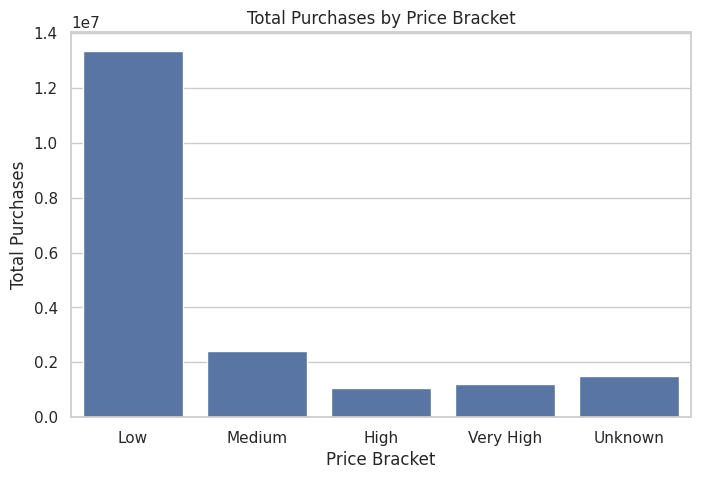

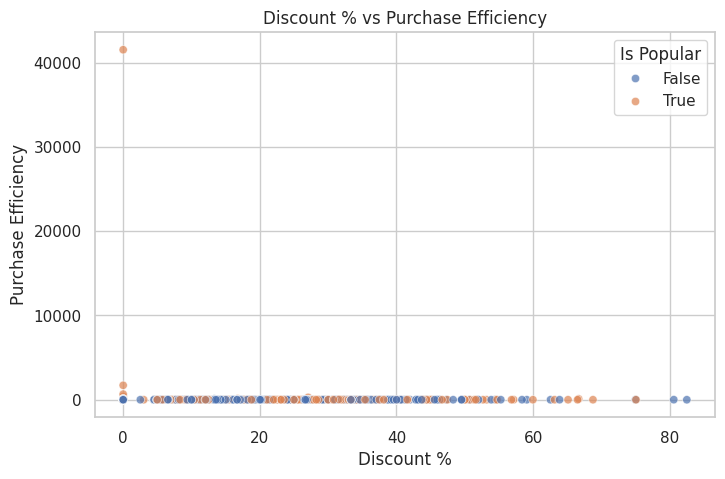

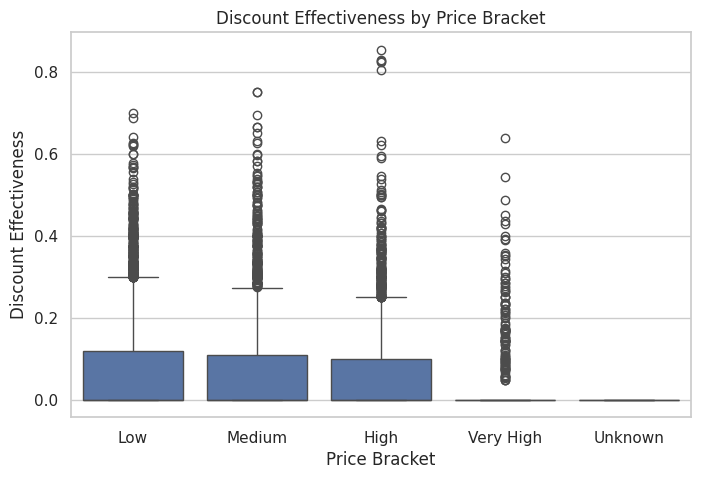


--- Key Visuals for Metrics ---



In [11]:
summary, segment, popularity = eda_df(final_df)

### EDA on Derivied Metrics

In [12]:
def eda_derived_metrics(df, clip_99=True):
  sns.set(style='whitegrid')
  df = df.copy()

  def plot_if_exists(col, func, *args, **kwargs):
      """Helper to skip plots if column doesn't exist."""
      if col in df.columns and df[col].notna().any():
          func(*args, **kwargs)
      else:
          print(f"[Skipping] Column '{col}' not found or empty.\n")

#Absolute Discount
  plot_if_exists('discount_amount', plt.figure, figsize=(8,5))
  if 'discount_amount' in df.columns:
      sns.histplot(df['discount_amount'].dropna(), bins=30)
      plt.title('Distribution of Discount Amount ($)')
      plt.xlabel('Discount Amount ($)')
      plt.show()

  #Discount Percentage (non-zero only)
  if 'discount_percentage' in df.columns:
      plt.figure(figsize=(8,5))
      nonzero = df[df['discount_percentage'] > 0]['discount_percentage']
      sns.histplot(nonzero, bins=30)
      plt.yscale('log')
      plt.title('Distribution of Discount Percentage (Non-zero)')
      plt.xlabel('Discount %')
      plt.show()

#Products per Price Bracket
  plot_if_exists('price_bracket', plt.figure, figsize=(8,5))
  if 'price_bracket' in df.columns:
      sns.countplot(x='price_bracket', data=df, order=['Low','Medium','High','Very High','Unknown'])
      plt.title('Number of Products per Price Bracket')
      plt.xlabel('Price Bracket')
      plt.ylabel('Count')
      plt.show()

#Average Purchases by Price Bracket
  if {'price_bracket', 'bought_in_last_month_clean'}.issubset(df.columns):
      plt.figure(figsize=(8,5))
      sns.barplot(
          data=df,
          x='price_bracket',
          y='bought_in_last_month_clean',
          order=['Low','Medium','High','Very High','Unknown']
      )
      plt.title('Average Purchases by Price Bracket')
      plt.xlabel('Price Bracket')
      plt.ylabel('Avg Purchases (Last Month)')
      plt.show()

#Popular vs Less Popular Products
  plot_if_exists('is_popular', plt.figure, figsize=(8,5))
  if 'is_popular' in df.columns:
      sns.countplot(x='is_popular', data=df)
      plt.title('Number of Popular vs Less Popular Products')
      plt.xlabel('Popularity')
      plt.ylabel('Count')
      plt.show()

#Purchases in the Last Month
  plot_if_exists('bought_in_last_month_clean', plt.figure, figsize=(8,5))
  if 'bought_in_last_month_clean' in df.columns:
      plt.figure(figsize=(8,5))
      nonzero = df[df['bought_in_last_month_clean'] > 0]['bought_in_last_month_clean']
      sns.histplot(nonzero, bins=30)
      plt.xscale('log')
      plt.title('Purchases in Last Month (Log Scale)')
      plt.xlabel('Purchases')
      plt.show()

#Listed Price Distribution
  plot_if_exists('listed_price_clean', plt.figure, figsize=(8,5))
  if 'listed_price_clean' in df.columns:
      plt.figure(figsize=(8,5))
      positive_prices = df[df['listed_price_clean'] > 0]['listed_price_clean']
      sns.histplot(positive_prices, bins=30)
      plt.xscale('log')
      plt.title('Listed Price Distribution (Log Scale)')
      plt.xlabel('Listed Price ($)')
      plt.show()

#Clipped Purchases (99th percentile)
  if clip_99 and 'bought_in_last_month_clean' in df.columns:
      p99 = df['bought_in_last_month_clean'].quantile(0.99)
      plt.figure(figsize=(8,5))
      sns.histplot(df['bought_in_last_month_clean'].clip(upper=p99), bins=30)
      plt.title('Purchases (Clipped at 99th Percentile)')
      plt.xlabel('Purchases')
      plt.show()

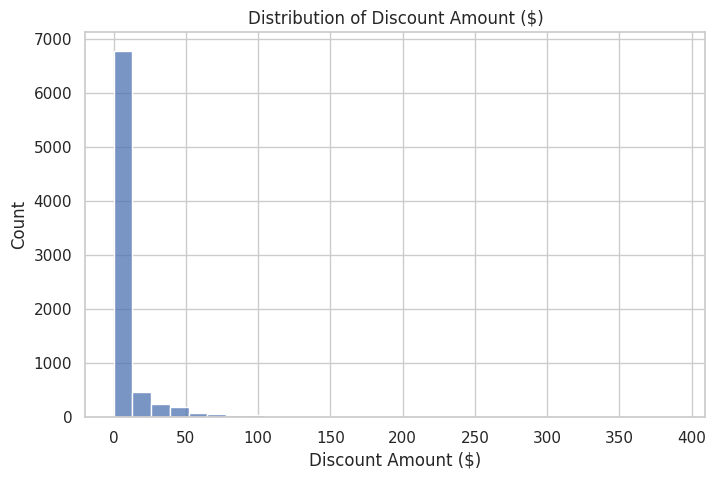

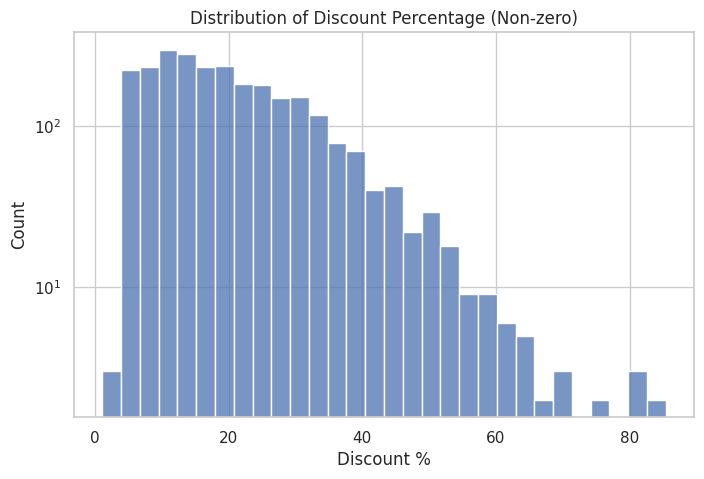

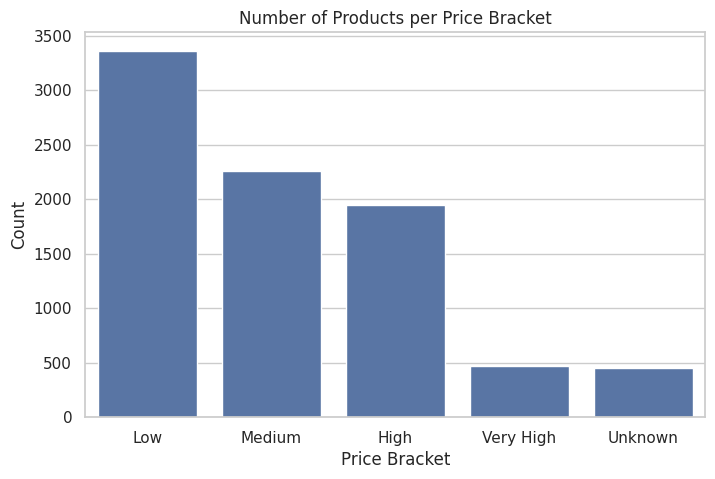

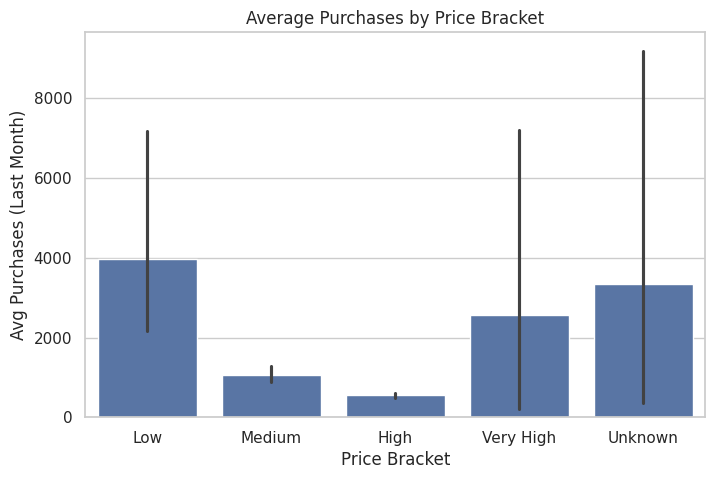

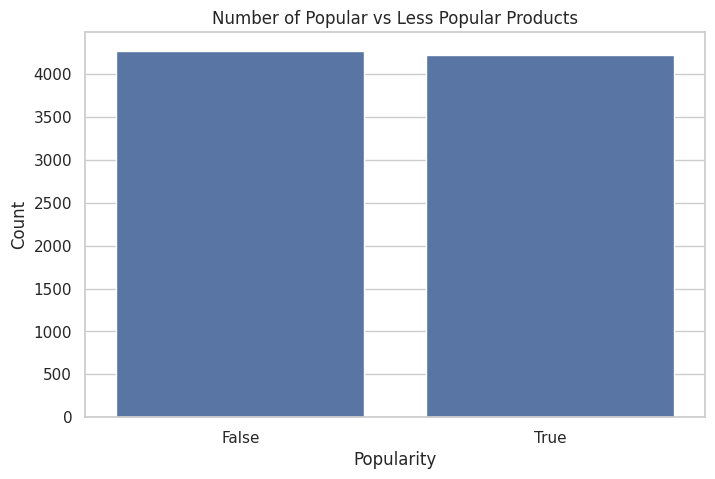

<Figure size 800x500 with 0 Axes>

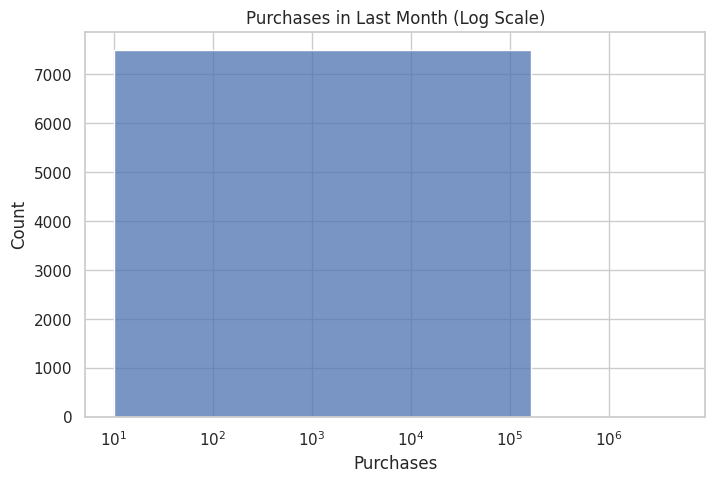

[Skipping] Column 'listed_price_clean' not found or empty.



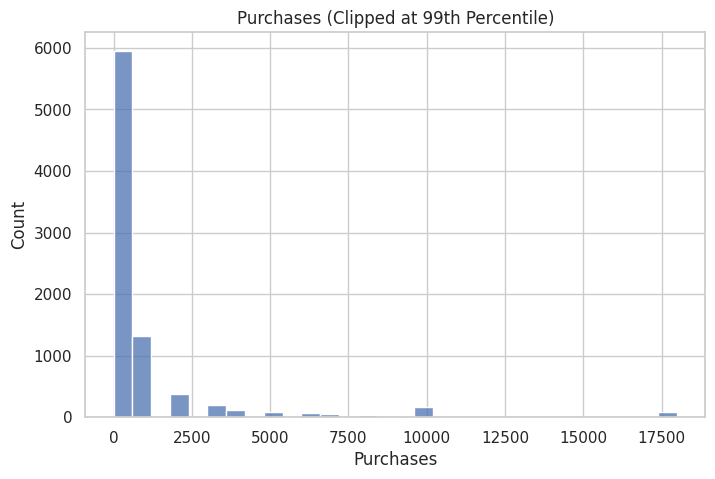

In [13]:
eda_derived_metrics(final_df, clip_99=True)

## Modeling

In [14]:
def modeling_metrics(df, features, target='bought_in_last_month_clean', log_transform=True, plot=True):
  from sklearn.model_selection import train_test_split
  from sklearn.linear_model import LinearRegression
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.metrics import mean_squared_error, r2_score

  X = df[features].fillna(0)
  y = df[target].fillna(0)

  for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = X[col].fillna(0)
    else:
        X[col] = X[col].astype(str).fillna('Unknown')
  X = pd.get_dummies(X, drop_first=True)
  y_trans = np.log1p(y) if log_transform else y.copy()

  # Train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)


  results = {}

  # Linear Regression
  lr = LinearRegression()
  lr.fit(X_train, y_train)
  y_pred_lr = lr.predict(X_test)
  results['LinearRegression'] = {
      'rmse': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
      'r2': r2_score(y_test, y_pred_lr),
      'coefficients': pd.Series(lr.coef_, index=X_train.columns)
  }

  # Random Forest
  rf = RandomForestRegressor(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)
  y_pred_rf = rf.predict(X_test)
  results['RandomForest'] = {
      'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
      'r2': r2_score(y_test, y_pred_rf),
      'feature_importances': pd.Series(rf.feature_importances_, index=X_train.columns)
  }
#summary
  summary = pd.DataFrame({
      'Model': results.keys(),
      'RMSE': [v['rmse'] for v in results.values()],
      'R2': [v['r2'] for v in results.values()]
  })
  print("\n--- Model Performance Summary ---\n")
  display(summary)

  if plot:
    plt.figure(figsize=(6,6))
    plt.scatter(np.expm1(y_test) if log_transform else y_test,
                np.expm1(y_pred_lr) if log_transform else y_pred_lr,
                alpha=0.5)
    plt.xlabel('Actual Purchases')
    plt.ylabel('Predicted Purchases (Linear Regression)')
    plt.title('Predicted vs Actual Purchases')
    plt.show()

  return results


--- Model Performance Summary ---



,Model,RMSE,R2
0,LinearRegression,4.452011,-2.587005
1,RandomForest,1.001851,0.818354


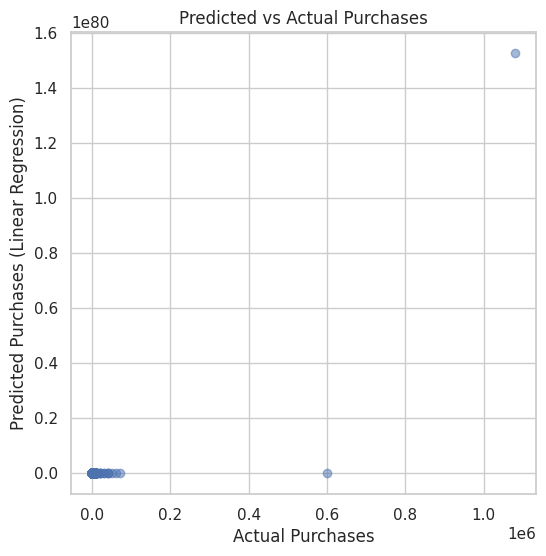

In [15]:
features = [
    'rating_numeric',
    'number_of_reviews',
    'original_price',
    'discounted_price',
    'discount_amount',
    'discount_percentage',
    'purchase_efficiency',
    'is_high_value_product',
    'price_bracket',
    'is_popular',
    'discount_effectiveness'
]

results = modeling_metrics(final_df, features)

##Visualizations for Modeling

<Figure size 1000x600 with 0 Axes>

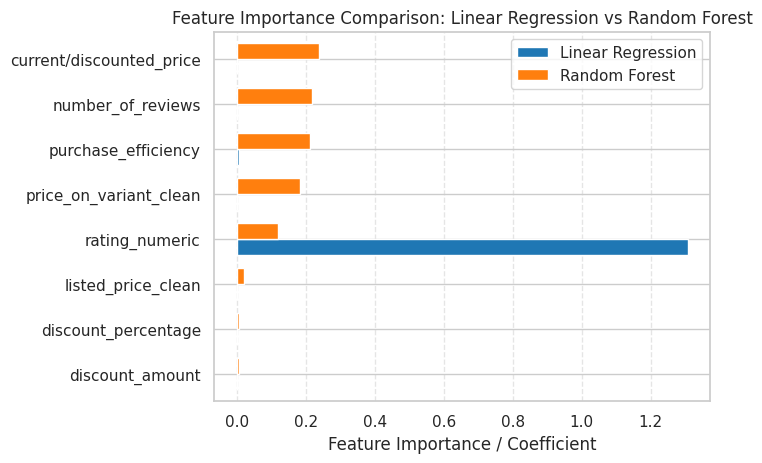

In [16]:
# Linear Regression Coefficients
lr_coefs = pd.Series({
    'rating_numeric': 1.307126,
    'purchase_efficiency': 0.005428,
    'current/discounted_price': -0.000522,
    'listed_price_clean': -0.000424,
    'number_of_reviews': -0.000084,
    'discount_amount': 0.000076,
    'discount_percentage': -0.000041,
    'price_on_variant_clean': 0.000002
})

# Random Forest Importances
rf_importances = pd.Series({
    'current/discounted_price': 0.237120,
    'number_of_reviews': 0.216965,
    'purchase_efficiency': 0.212326,
    'price_on_variant_clean': 0.182343,
    'rating_numeric': 0.119464,
    'listed_price_clean': 0.020241,
    'discount_percentage': 0.005842,
    'discount_amount': 0.005699
})

# Combine into one DataFrame
df_plot = pd.DataFrame({
    'Linear Regression': lr_coefs,
    'Random Forest': rf_importances
}).sort_values(by='Random Forest', ascending=True)  # sort by RF for easier viewing

# Plot
plt.figure(figsize=(10,6))
df_plot.plot(kind='barh', width=0.7, color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Feature Importance / Coefficient')
plt.title('Feature Importance Comparison: Linear Regression vs Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


In [22]:
results['RandomForest']['feature_importances'].sort_values(ascending=False).head(10)


,0
is_popular,0.478392
number_of_reviews,0.157210
purchase_efficiency,0.147511
original_price,0.073167
discounted_price,0.055635
rating_numeric,0.047603
discount_amount,0.010896
price_bracket_Low,0.010323
discount_percentage,0.009276
discount_effectiveness,0.008632


## Business Insights

## Dataset Overview

- Number of Rows:  8493
- Number of columns: 17
- Missing values per column:
  - title                            0
  - rating_numeric                  41
  - number_of_reviews                0
  - bought_in_last_month_clean       0
  - original_price                 454
  - discounted_price               454
  - discount_amount                454
  - discount_percentage              0
  - buy_box_availability             0
  - delivery_details                 0
  - sustainability_badges            0
  - product_url                      0
  - purchase_efficiency           4154
  - is_high_value_product            0
  - price_bracket                    0
  - is_popular                       0
  - discount_effectiveness           0
  - dtype: int64
- Number of Duplicated Rows: 0

## Data Cleaning Insights

In [24]:
numeric_cols = ['bought_in_last_month_clean', 'number_of_reviews',
                'original_price','discounted_price','discount_amount',
                'discount_percentage','purchase_efficiency','discount_effectiveness']
print(final_df[numeric_cols].describe())


       bought_in_last_month_clean  number_of_reviews  original_price  \
count                8.493000e+03        8493.000000     8039.000000   
mean                 2.300375e+03         194.063229      144.324818   
std                  5.679145e+04         816.084753      182.307799   
min                  0.000000e+00           0.000000        1.000000   
25%                  1.000000e+02           0.000000       26.990000   
50%                  3.000000e+02           4.000000       72.990000   
75%                  9.000000e+02         247.000000      179.990000   
max                  4.880000e+06       55704.000000      999.990000   

       discounted_price  discount_amount  discount_percentage  \
count       8039.000000      8039.000000          8493.000000   
mean         135.704785         8.620033             6.449880   
std          175.846406        25.229191            11.905835   
min            1.000000         0.000000             0.000000   
25%           24.405000   

The dataset reveals a highly skewed distribution of purchases and reviews, with most products having low activity but a few extreme outliers driving totals. Prices range widely, and while most discounts are modest, certain high-discount products show substantial purchase effectiveness. Derived metrics like purchase_efficiency highlight products with unusually strong purchase-to-review ratios. Cleaning and transformation ensured consistent numeric columns and addressed missing or zero values, making the data ready for analysis, segmentation, and predictive modeling. These patterns suggest that targeted discount strategies and attention to high-potential products could meaningfully influence sales outcomes.

In [25]:
# Prices with $0, negative discounts
print(final_df[final_df['discount_amount'] <= 0][['title','original_price','discounted_price','discount_amount']].head())
# Uncommon price strings or missing badges
print(final_df['sustainability_badges'].value_counts(dropna=False))

                                               title  original_price  \
0  (2) Kicker 40PS692 6x9" 180w Polaris/ATV/UTV/R...          169.96   
1  10 Duracell 357 303 A76 PX76 SR44W/SW LR44 AG1...           19.17   
5  12-Pack Duracell 2025 Batteries 3.0 Volt Lithi...           12.00   
6  12-Pack Duracell 2450 Batteries 3.0 Volt Lithi...            1.00   
9  2 Kicker 43DSC504 D-Series 5.25" 200W 2-Way 4-...           74.99   

   discounted_price  discount_amount  
0            169.96              0.0  
1             19.17              0.0  
5             12.00              0.0  
6              1.00              0.0  
9             74.99              0.0  
sustainability_badges
                                  7743
Works with Alexa                   194
Carbon impact                      171
Small Business                     130
Manufacturing practices             65
Energy efficiency                   52
Energy efficiency +3 more           35
Alexa Built-in                      35

In [26]:
cat_cols = ['buy_box_availability','delivery_details','price_bracket','is_popular','is_high_value_product']
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(final_df[col].value_counts(dropna=False))



Column: buy_box_availability
buy_box_availability
Add to cart    5270
               3223
Name: count, dtype: int64

Column: delivery_details
delivery_details
Delivery Mon, Sep 1       4045
                          2794
Delivery Tue, Sep 2        552
Delivery Thu, Sep 4        401
Delivery Fri, Sep 5         98
                          ... 
$140.09 delivery             1
Delivery Sep 4 - 12          1
$81.11 delivery              1
Delivery Sep 8 - Oct 1       1
Delivery Sep 5 - 29          1
Name: count, Length: 187, dtype: int64

Column: price_bracket
price_bracket
Low          3365
Medium       2256
High         1951
Very High     467
Unknown       454
Name: count, dtype: int64

Column: is_popular
is_popular
False    4273
True     4220
Name: count, dtype: int64

Column: is_high_value_product
is_high_value_product
False    4477
True     4016
Name: count, dtype: int64


The dataset is skewed toward low-cost, low-discount products with sparse sustainability info and inconsistent delivery data. This suggests discount strategies, high-value product focus, and clean delivery info could be leveraged for business insights and modeling.

## Basic Metrics

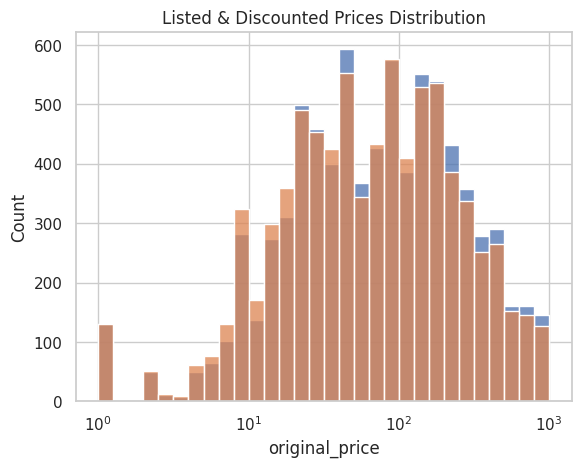

In [28]:
sns.histplot(final_df['original_price'], bins=30, log_scale=(True, False))
sns.histplot(final_df['discounted_price'], bins=30, log_scale=(True, False))
plt.title('Listed & Discounted Prices Distribution')
plt.show()


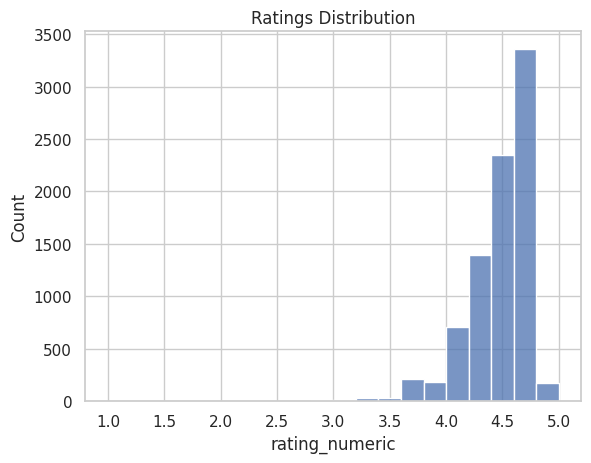

In [30]:
sns.histplot(final_df['rating_numeric'], bins=20)
plt.title('Ratings Distribution')
plt.show()


## Derived metrics Insight

In [33]:
final_df.sort_values('discount_amount', ascending=False)[['title','original_price','discounted_price','discount_amount']].head(10)


,title,original_price,discounted_price,discount_amount
2306,Canon Megatank GX7120 Wireless All-in-One Prin...,863.99,474.00,389.99
3801,"Garmin epix Gen 2, Premium active smartwatch, ...",899.99,549.00,350.99
8181,Victrola Stream Onyx - Wi-Fi Streaming 2-Speed...,799.99,450.50,349.49
8394,Zebra - GK420t Thermal Transfer Desktop Printe...,528.59,190.95,337.64
3932,Google Pixelbook Go - Lightweight Chromebook L...,649.00,333.31,315.69
7262,Sonos Outdoor by Sonance,879.00,569.00,310.00
6843,"Samsung 27"" Odyssey QHD G65B Curved Gaming Mon...",699.99,399.99,300.00
3597,Fujitsu FI-7160 - Document Scanner - Duplex - ...,519.99,237.00,282.99
6887,Samsung Electronics Galaxy Watch 4 Classic 42m...,308.48,44.99,263.49
6924,Samsung Galaxy Watch Ultra (2024) 47mm LTE AI ...,649.99,394.91,255.08


-- The products that are discounted the highest tend to be electronics

In [34]:
final_df.sort_values('purchase_efficiency', ascending=False)[['title','bought_in_last_month_clean','number_of_reviews','purchase_efficiency']].head(10)


,title,bought_in_last_month_clean,number_of_reviews,purchase_efficiency
6755,"SAMSUNG Galaxy Tab S10 Ultra (14.6"", Wi-Fi) SM...",1080000.0,26.0,41538.461538
2248,Canon EF 24-70mm f/2.8L USM Standard Zoom Lens...,1315780.0,767.0,1715.488918
6993,SanDisk 512GB microSD Express microSD Card - U...,2000.0,3.0,666.666667
2881,Dell Pro Dock WD25 - USB Type-C with DP Alt Mo...,400.0,1.0,400.000000
4850,Kingston Fury Renegade G5 2048GB NVMe SSD | PC...,4813.0,17.0,283.117647
2708,DJI Osmo Mobile 7P Gimbal Stabilizer for iPhon...,300.0,2.0,150.000000
2884,Dell Pro Thunderbolt 4 Smart Dock SD25TB4 – US...,500.0,4.0,125.000000
2011,Brother Genuine P-Touch TZe White Print on Bla...,600.0,5.0,120.000000
3589,Fujifilm QuickSnap Flash 400 One-Time-Use Came...,2000.0,19.0,105.263158
5989,"OnePlus Watch 3 Obsidian Titantium, 32GB, 120-...",100.0,1.0,100.000000


Notes:
- High purchase volumes
  - Some products, like the SAMSUNG Galaxy Tab S10 Ultra and Canon EF 24-70mm Lens, have extremely high purchase counts (>1 million units).
  - Despite high sales, the number of reviews is relatively low, suggesting low review engagement or aggregated sales data.

- Purchase efficiency highlights
  -  The Galaxy Tab shows 41,538 purchases per review, an extreme outlier.
  -  Products with efficiency >1000 indicate very strong demand relative to review volume.

- Review-poor but popular products
  - Many high-value electronics have disproportionately low reviews relative to purchases.
  - These products may benefit from marketing initiatives encouraging reviews to boost social proof.

- Potential data anomalies
  - Efficiency numbers that are extremely high may indicate aggregation, missing review data, or reporting inconsistencies.
    - For example, 1.3 million purchases for a Canon lens vs 767 reviews could reflect bulk sales or imported data errors.

In [36]:
final_df.sort_values('discount_effectiveness', ascending=False)[['title','discount_percentage','discount_effectiveness']].head(10)


,title,discount_percentage,discount_effectiveness
6887,Samsung Electronics Galaxy Watch 4 Classic 42m...,85.415586,0.854156
6919,Samsung Galaxy Watch 4 Classic 42mm Smartwatch...,82.925996,0.829260
5678,Monster Clarity 101Plus AirLinks Wireless Earb...,82.562940,0.825629
5690,"Monster Shock Portable Bluetooth Speaker,30W L...",82.504125,0.825041
5683,"Monster Open Ear AC322, Bluetooth 5.4 Headset,...",80.592976,0.805930
6047,OtterBox Thin Flex Series case for The Samsung...,75.062552,0.750626
5674,"Monster Bluetooth Speaker, IPX8 Shower Speaker...",75.006251,0.750063
1535,Apple iPhone 12 mini Silicone Case with MagSaf...,70.014003,0.700140
5643,Microsoft Xbox One Kinect Sensor Bar [Xbox One...,69.452846,0.694528
8298,Wyze Battery Charging Dock for Battery Cam Pro,68.765638,0.687656


Products with higher discount percentages tend to show higher discount effectiveness, indicating that steep discounts drive more consumer purchases.

## Modeling insights

is_popular                 0.478392
number_of_reviews          0.157210
purchase_efficiency        0.147511
original_price             0.073167
discounted_price           0.055635
rating_numeric             0.047603
discount_amount            0.010896
price_bracket_Low          0.010323
discount_percentage        0.009276
discount_effectiveness     0.008632
price_bracket_Medium       0.000552
price_bracket_Unknown      0.000524
is_high_value_product      0.000215
price_bracket_Very High    0.000064
dtype: float64


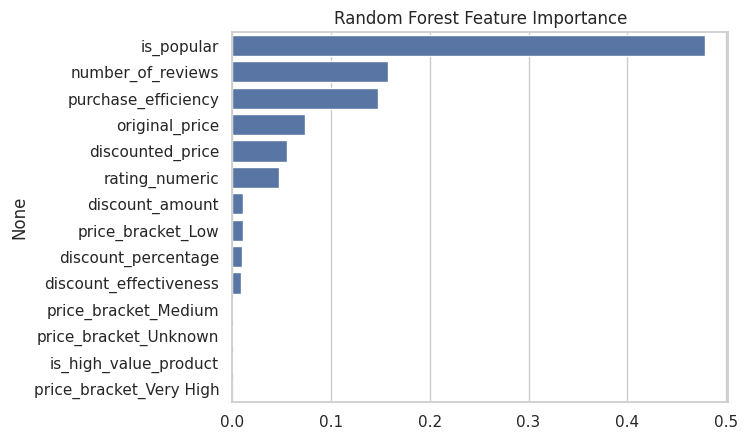

In [37]:
rf_importance = results['RandomForest']['feature_importances'].sort_values(ascending=False)
print(rf_importance)
sns.barplot(x=rf_importance.values, y=rf_importance.index)
plt.title('Random Forest Feature Importance')
plt.show()

Notes:
Popularity in the product is the driving factor in consumer purchasing.

## Actionable Insights

- Discounts drive purchases: Products with high discounts (70–85%) show the strongest purchase impact.

- Popular items matter: is_popular and high purchase_efficiency are top predictors of sales; focus marketing and upselling here.

- Pricing strategy: Low- and mid-priced products dominate; consider strategic discounts and bundles for high-value items.

- Reviews influence sales: Products with few reviews but high purchases may need review campaigns to improve credibility.

- Buy box & delivery: Standardize buy box availability and delivery info to improve conversions.

- Sustainability marketing: Most products lack sustainability badges; promote eco-friendly products to attract conscious buyers.

- Actionable targeting: Use modeling insights to identify underperforming products that could benefit from discounts or marketing campaigns.